# Differentiable Atmosphere

This notebook introduces a differentiable atmosphere model useful for propagating satellites in low-Earth orbit with *heyoka.py*. The model extends the ideas introduced in ESA's [cascade](https://esa.github.io/cascade/utilities/simple_atmosphere.html) simulations for the long term propagation of orbital debris enriching that model with the dependence on longitude, latitude, solar flux, local time and accounting for Earth oblateness via the Geodetic coordinates.

```{note}
All of the developments here presented explicitly are implemented and part of the *heyoka.model* module, check the notebook: [thermoNETs](<./thermoNETs.ipynb>).
```

```{note}
The differentiable atmosphere ideas and results are published in the paper:
*Izzo, Dario*, *Giacomo Acciarini*, and *Francesco Biscani*. "NeuralODEs for VLEO simulations: Introducing thermoNET for Thermosphere Modeling." arXiv preprint arXiv:2405.19384 (2024).
```

## Background

We leverage the key observation that the thermosphere is well approximated (at any given time, and location) by an exponential behavior with respect to the altitude. 

The thermosphere is also subject to variations at different longitude, latitude, and times, due to seasonal variations, diurnal variations, geomagnetic storms, and more. 

We thus assume the density profile as a sum of exponentials in the form:

$$
\rho(h) = \sum_i \alpha_i \ \textrm{exp}(-\beta_i (h-\gamma_i))
$$

and use a neural network to learn $\alpha_i, \beta_i, \gamma_i$ as a function of longitude, latitude, solar conditions,  times, etc.... In the equation above, $h$ is the geodetic altitude, and $\alpha_i, \beta_i, \gamma_i$ are the exponential parameters, which will be predicted using a neural network. 

To enhance the training, we do not directly learn these coefficients, but their variations w.r.t. an underlying average value (i.e., $\overline{\alpha}_i, \overline{\beta}_i, \overline{\gamma}_i$) precomputed minimizing the loss of the above equation compared to the target density (as done in [cascade](https://esa.github.io/cascade/utilities/simple_atmosphere.html)). 

This way, the neural model only needs to learn a correction to the average parameter, as defined by:

$$
\begin{align*}
\alpha_i&=\overline{\alpha}_i(1+f\delta \alpha_i)\\
\beta_i&=\overline{\beta}_i(1+f\delta \beta_i)\\
\gamma_i&=\overline{\gamma}_i(1+f\delta \gamma_i)
\end{align*}
$$

where the factor $f=0.9$ is used to limit the variations and avoid numerical instabilities of the exponential. 

At the end, our neural differetiable atmospheric model will thus be written as:

$$
\rho = \sum_i \overline{\alpha}_i(1+f\delta \alpha_i) \ \textrm{exp}\bigg(-\overline{\beta}_i(1+f\delta \beta_i) \big(h-\overline{\gamma}_i(1+f\delta \gamma_i)\big)\bigg)
$$

where,

$$
[\delta \alpha_i, \delta \beta_i, \delta \gamma_i ]^T = \mathcal{N}_\theta(\pmb{x})
$$

We have indicated with $\pmb{x}$ the input parameters that capture the density variations at a given, fixed, altitude $h$.

Let us make some imports:

In [1]:
import heyoka as hk

import numpy as np
import datetime
import time
from scipy.integrate import solve_ivp
from nrlmsise00 import msise_flat
import matplotlib.pyplot as plt

For training the neural network, we need thermospheric density values that can be used as target. In this case study, we use [NRLMSISE-00](https://en.wikipedia.org/wiki/NRLMSISE-00) (a popular empirical density model in the community), however, the same approach can also be extended to other models ([JB-08](https://ccmc.gsfc.nasa.gov/models/JB2008~2008/), [HASDM](https://www.sciencedirect.com/science/article/pii/S0273117705002048), etc.). We thus assume our parameters $\delta \alpha_i, \delta \beta_i, \delta \gamma_i$ are a function of the [NRLMSISE-00](https://en.wikipedia.org/wiki/NRLMSISE-00) input parameters (except the altitude ofc.).

We thus train the network with the following inputs:
* geodetic latitude normalized between `[-1,1]`
* sine of geodetic longitude 
* cosine of geodetic longitude
* sine of seconds in the day, where seconds in the day are first transformed in `[0,2$\pi$]`
* cosine of seconds in the day, where seconds in the day are first transformed in `[0,2$\pi$]`
* F10.7 normalized between `[-1,1]`, using the bounds `[60.,290.]`
* F10.7 81-day average normalized between `[-1,1]`, using the bounds `[60.,190.]`
* Ap index normalized between `[-1,1]`, using the bounds `[0.,140.]`

The network training was done using [PyTorch](https://pytorch.org/) and resulted in weights and biases can be found under `data/nrlmsise00_flattened_nw.txt`.
We now load the model flattened weights and biases, and construct the `heyoka.ffnn`

```{note}
For a tutorial on how to transfer the weights and biases from a torch model to heyoka.py, check out the tutorial: [Interfacing torch to heyoka.py](<./torch_and_heyoka.ipynb>)
```


We instantiate the state variables:

In [3]:
x,y,z,vx,vy,vz=hk.make_vars("x","y","z","vx","vy","vz")

However, the neural network model, similar to [NRLMSISE-00](https://en.wikipedia.org/wiki/NRLMSISE-00) and other models, accepts the geodetic coordinates as inputs (also the altitude $h$ must be computed using the geodetic coordinates). 

Here, we use the method discussed in ["Physical Geodesy" by Heiskanen and Moritz, 1967](https://library.wur.nl/WebQuery/titel/1236290), to transform the Cartesian coordinates into geodetic ones. 
For the Earth ellipsoid parameters, we use the [WGS-84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS_84) ellipsoid. 

The resulting method, implemented in heyoka, is thus:

In [4]:
#here we use the solution from: "Physical Geodesy" by Heiskanen and Moritz, 1967
def from_position_to_geodetic(x,y,z,a_earth=6378137.0,b_earth=6356752.314245,iters=4):
    long=hk.atan2(y,x)
    p=hk.sqrt(x**2+y**2)
    e=np.sqrt((a_earth**2-b_earth**2)/a_earth**2)
    phi=hk.atan(z/p/(1-e**2))
    #we iterate to improve the solution
    for _ in range(iters):            
        N=a_earth**2/hk.sqrt(a_earth**2*hk.cos(phi)**2+b_earth**2*hk.sin(phi)**2)
        h=p/hk.cos(phi)-N
        phi=hk.atan(z/p/(1-e**2*N/(N+h)))
    return h/1e3,phi,long

Note that we need to decide on a fixed number of iterations to use as to reconstruct the geodetic coordinates from the Cartesian ones. Running an experiment and limiting the altitude in the range $h \in [100, 1000]$ Km we find maximum errors (in reconstructing the altitude), of 37m for 2 iterations, 0.2m for 3 iterations, and 2cm for 4 iterations.

We can then settle for now on four iterations (3 or even 2 could actually be good enough) and compute the symbolic expression of the inversions:

In [5]:
altitude,lat,lon=from_position_to_geodetic(x,y,z)
print("As an example here is the symbolic expression for the altitude: \n", altitude)

As an example here is the symbolic expression for the altitude: 
 (((0.0010000000000000000 * (x**2.0000000000000000 + y**2.0000000000000000)**0.50000000000000000) / cos(atan((z / ((1.0000000000000000 - ((272331606109.84375 * cos(atan((z / ((1.0000000000000000 - ((272331606109.84375 * cos(atan((z / ((1.0000000000000000 - ((272331606109.84375 * cos(atan(((1.0067394967423335 * z) / (x**2.0000000000000000 + y**2.0000000000000000)**0.50000000000000000)))) / ((x**2.0000000000000000 + y**2.0000000000000000)**0.50000000000000000 * ((40408299984659.156 * sin(atan(((1.0067394967423335 * z) / (x**2.0000000000000000 + y**2.0000000000000000)**0.50000000000000000)))**2.0000000000000000) + (40680631590769.000 * cos(atan(((1.0067394967423335 * z) / (x**2.0000000000000000 + y**2.0000000000000000)**0.50000000000000000)))**2.0000000000000000))**0.50000000000000000))) * (x**2.0000000000000000 + y**2.0000000000000000)**0.50000000000000000))))) / ((x**2.0000000000000000 + y**2.0000000000000000)**0.500000000

We now can define all the normalized inputs to feed the neural network.

In [6]:
lat_n=lat/np.pi*2
sin_lon=hk.sin(lon)
cos_lon=hk.cos(lon)
# This is the date we assume to start our integration at
date0=datetime.datetime(2009, 1, 2, 8, 0)
offset=date0.second+date0.minute*60.+date0.hour*3600.
sec_in_day_n=(hk.time+offset)/86400.*2*np.pi
cos_sec_in_day=hk.cos(sec_in_day_n)
sin_sec_in_day=hk.sin(sec_in_day_n)
# We will integrate for 10 hours, we can thus assume these values are constant.
# We compute their values using the nrlmsise00 toolbox and querying the date0. We then normalize to obtain:
f107_n, f107A_n, ap_n=(0.17409463226795197, -0.5575244426727295, 0.1701483279466629)

We have everything we need to instantiate our differentiable, neural model for the atmosphere: let us load the pre-trained weights and biases for the `ffnn`:

In [7]:
flattened_nw=np.loadtxt('data/nrlmsise00_flattened_nw.txt')

and instantiate the `heyoka.ffnn`:

In [8]:
model_heyoka=hk.model.ffnn(inputs=[lat_n,sin_lon,cos_lon,sin_sec_in_day, cos_sec_in_day, hk.expression(f107_n), hk.expression(f107A_n), hk.expression(ap_n)],
                           nn_hidden=[32,32], 
                           n_out=12, 
                           activations=[hk.tanh,hk.tanh,hk.tanh], 
                           nn_wb=flattened_nw)


The network above predicts the $\delta \alpha_i$, $\delta \beta_i$, $\delta \gamma_i$, to use in the expression below:

$$
\rho = \sum_i \overline{\alpha}_i(1+f\delta \alpha_i) \ \textrm{exp}\bigg(-\overline{\beta}_i(1+f\delta \beta_i) \big(h-\overline{\gamma}_i(1+f\delta \gamma_i)\big)\bigg)
$$

The values of the various $\overline{\alpha}_i, \overline{\beta}_i, \overline{\gamma}_i$ have been precomputed as to fit an average atmospheric model, similarily as done in ESA's [cascade](https://esa.github.io/cascade/utilities/simple_atmosphere.html) simulations. Their values are here reported explicitly:

In [9]:
# these are the constant
fit_params_all=np.zeros((1,12))
# alpha
fit_params_all[0,0]=1.1961831205553608e-06
fit_params_all[0,3]=0.7521974444389343
fit_params_all[0,6]=3.916130530967621e-09
fit_params_all[0,9]=1.4778674432228828e-13
# beta
fit_params_all[0,1]=0.04639218747615814
fit_params_all[0,4]=0.18178749084472656
fit_params_all[0,7]=0.019965510815382004
fit_params_all[0,10]=0.004425965249538422
#gamma
fit_params_all[0,2]=5.996347427368164
fit_params_all[0,5]=21.895925521850586
fit_params_all[0,8]=2.3234505653381348
fit_params_all[0,11]=0.26730024814605713

and used to define the final differentiable model:

In [10]:
def density(altitude, model, factor=0.9):
    density=0.
    for i in range(0,fit_params_all.shape[1]-1,3):
        density += (fit_params_all[0,i].item()*(1+factor*model[i])*hk.exp(-fit_params_all[0,i+1].item()*(1.+factor*model[i+1])*(altitude-(fit_params_all[0,i+2].item()*(1.+factor*model[i+2])))))
    return density

Let's now use the function to instantiate the neutral density model with feed-forward neural network correction:

In [11]:
density_nn = density(altitude=altitude, model=model_heyoka)

Let's now do the same, but zeroing out the correction terms: this corresponds to a density model representing on average all latitudes, longitudes, time of days etc ... and only varying with the geodetic altitude.

In [12]:
density_fit_global = density(altitude=altitude, model=model_heyoka, factor=0.)

## Numerical Integration with Differentiable Atmosphere

All right... we have a differentiable density model defined via a functional form and NN coefficients, and one defined by a global fit.

How can these be used for predicting the orbit of a satellite in low-Earth orbit? And how do they compare to `scipy` integration using the `NRLMSISE-00` model itself?

We are now ready to set up numerical integrations of a satellite subject to different atmospheric models. We do so, for the purpose of this example, assuming the only forces acting on the satellite are the air drag and the gravitational attraction to a central body.

$$
\begin{array}{l}
\ddot{\mathbf r} = -\dfrac{\mu}r^3 \mathbf r -\dfrac {A\rho(\mathbf r, t)}{2m} C_d |\mathbf v|\mathbf v
\end{array}
$$

```{note}
This dynamics does not consider winds, nor the Earth rotation, both effects that are easily modelled, but would here just hinder the point we are trying to make.```

First some useful constants:

In [13]:
#First we need to set some variables useful for integration:
mu = 3.986004407799724e14   #Earth gravitational parameter SI
r_earth = 6378.1363*1e3     #Earth radius SI
initial_h=350.*1e3          #Satellite's initial altitude SI
mass=200                    #mass of the satellite SI
area=2#                     drag cross-sectional area of the satellite in SI
cd=2.2#                     drag coefficient [-]
bc = mass/(cd*area)         #ballistic coefficient in SI
#we assume a circular orbit at first
initial_state=[r_earth+initial_h,0.,0., 0., np.sqrt(mu/(r_earth+initial_h)),0.]
#finally, we need to de-normalize the solar indices of the day of the integration:
f107=(1+f107_n)/2*(290.-60.)+60.
f107A=(1+f107A_n)/2*(190.-60.)+60.
ap=(1+ap_n)/2*(140.-0.)+0.


### Scipy + NRLMSISE-00

This is the standard scipy integration, using NRLMSISE-00 as neutral density model

```{warning}
to run this, the [nrlmsise00](https://pypi.org/project/nrlmsise00/) pypi package shall be first installed
```

First, we define the dynamics:

In [15]:
def from_position_to_geodetic_(x,y,z,a_earth=6378137.0,b_earth=6356752.314245,iters=4):
    long=np.arctan2(y,x)
    p=np.sqrt(x**2+y**2)
    e=np.sqrt((a_earth**2-b_earth**2)/a_earth**2)
    phi=np.arctan(z/p/(1-e**2))
    #we iterate to improve the solution
    for _ in range(iters):            
        N=a_earth**2/np.sqrt(a_earth**2*np.cos(phi)**2+b_earth**2*np.sin(phi)**2)
        h=p/np.cos(phi)-N
        phi=np.arctan(z/p/(1-e**2*N/(N+h)))
    return h/1e3,phi,long

def dxdt(t, state, mu, f107A, f107, ap, bc, date0):
    x,y,z,vx,vy,vz=state
    r=np.sqrt(x**2+y**2+z**2)
    h,lat,long=from_position_to_geodetic_(x,y,z)
    #nrlmsise-00 density (takes: datetime, altitude [km], latitude [deg], longitude [deg], f107, f107A, ap)
    rho=msise_flat(time=date0+datetime.timedelta(seconds=t), alt=h, lat=np.rad2deg(lat), lon=np.rad2deg(long), f107a=f107A, f107=f107, ap=ap)[5]*1e3
    adrag_x=-1/2*rho*np.sqrt(vx**2+vy**2+vz**2)*vx/bc
    adrag_y=-1/2*rho*np.sqrt(vx**2+vy**2+vz**2)*vy/bc
    adrag_z=-1/2*rho*np.sqrt(vx**2+vy**2+vz**2)*vz/bc
    ax=-mu*x/r**3+adrag_x
    ay=-mu*y/r**3+adrag_y
    az=-mu*z/r**3+adrag_z
    return np.array([vx,vy,vz,ax,ay,az])
    

Then, we set up the integration:
    
```{note}
To have a fair comparison, as integrator, we use `DOP853` with absolute and relative tolerances of $10^{-13}$, and we then select the same tolerances for the Taylor integrator)
```

In [16]:
t_span=(0.,60.*60*10.) #10 hours propagation

In [17]:
%%timeit
sol = solve_ivp(dxdt, 
                t_span, 
                initial_state, 
                args=(mu, f107A, f107, ap, bc, date0), 
                method='DOP853',
                rtol=1e-13,
                atol=1e-14)

457 ms ± 3.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


For plotting (later on) we perform again the integration once to record the result.

In [18]:
sol = solve_ivp(dxdt, 
                t_span, 
                initial_state, 
                args=(mu, f107A, f107, ap, bc, date0), 
                method='DOP853',
                rtol=1e-13,
                atol=1e-14)
res_x_scipy_nrlmsise00=sol.y[0,:]
res_y_scipy_nrlmsise00=sol.y[1,:]
res_z_scipy_nrlmsise00=sol.y[2,:]
res_vx_scipy_nrlmsise00=sol.y[3,:]
res_vy_scipy_nrlmsise00=sol.y[4,:]
res_vz_scipy_nrlmsise00=sol.y[5,:]

### Heyoka + differentiable atmosphere (NN)

Here we do the same as above, but using `heyoka`'s Taylor method, and the differentiable atmosphere model.

First, we define the dynamics:

In [19]:
akepler_x=-mu*x*(x**2+y**2+z**2)**(-3/2)
akepler_y=-mu*y*(x**2+y**2+z**2)**(-3/2)
akepler_z=-mu*z*(x**2+y**2+z**2)**(-3/2)

adragx=-1/2*density_nn*vx*hk.sqrt(vx**2+vy**2+vz**2)/bc
adragy=-1/2*density_nn*vy*hk.sqrt(vx**2+vy**2+vz**2)/bc
adragz=-1/2*density_nn*vz*hk.sqrt(vx**2+vy**2+vz**2)/bc

dyn_drag=[(x,vx), (y,vy), (z,vz), (vx,akepler_x+adragx), (vy,akepler_y+adragy), (vz,akepler_z+adragz)]


We first compile the integrator:

In [20]:
start_time = time.time()
ta=hk.taylor_adaptive(
    dyn_drag,
    initial_state,
    compact_mode=True,
    tol=1e-14,
)
print(f'{time.time()-start_time} to build the integrator')

0.4561591148376465 to build the integrator


And then, we can finally perform the integration:

In [21]:
%%timeit
ta.state[:] = initial_state
ta.time=0.
sol_heyoka_nn=ta.propagate_grid(sol.t)

2.68 ms ± 9.66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


For plotting (later on) we perform again the integration once to record the result.

In [22]:
ta.state[:] = initial_state
ta.time=0.
sol_heyoka_nn=ta.propagate_grid(sol.t)
res_x_heyoka_nn=sol_heyoka_nn[-1][:,0]
res_y_heyoka_nn=sol_heyoka_nn[-1][:,1]
res_z_heyoka_nn=sol_heyoka_nn[-1][:,2]
res_vx_heyoka_nn=sol_heyoka_nn[-1][:,3]
res_vy_heyoka_nn=sol_heyoka_nn[-1][:,4]
res_vz_heyoka_nn=sol_heyoka_nn[-1][:,5]

*heyoka.py* integration with a differentiable atmosphere is more than 100x times faster than `scipy` with `NRLMSISE-00` !

## Lets plot the results to check the accuracy

All right! But what about the accuracy? Does the trained neural network manage to accurately represent `NRLMSISE-00`, without accumulating too much error during integration?

For this, we setup a test where we compare: 
* scipy with `NRLMSISE-00`
* heyoka with NN
* heyoka with global fit

But first, let's integrate the equations of motion using the global fit:


In [23]:
akepler_x=-mu*x*(x**2+y**2+z**2)**(-3/2)
akepler_y=-mu*y*(x**2+y**2+z**2)**(-3/2)
akepler_z=-mu*z*(x**2+y**2+z**2)**(-3/2)

adragx=-1/2*density_fit_global*vx*hk.sqrt(vx**2+vy**2+vz**2)/bc
adragy=-1/2*density_fit_global*vy*hk.sqrt(vx**2+vy**2+vz**2)/bc
adragz=-1/2*density_fit_global*vz*hk.sqrt(vx**2+vy**2+vz**2)/bc

dyn_drag_fit_global=[(x,vx), (y,vy), (z,vz), (vx,akepler_x+adragx), (vy,akepler_y+adragy), (vz,akepler_z+adragz)]

start_time = time.time()
ta=hk.taylor_adaptive(
    dyn_drag_fit_global,
    initial_state,
    compact_mode=True,
    tol=1e-14,
)
print(f'{time.time()-start_time} to build the integrator')


0.2512080669403076 to build the integrator


In [24]:
%%timeit
ta.state[:] = initial_state
ta.time=0.
sol_heyoka_fit_global=ta.propagate_grid(sol.t)

298 µs ± 752 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
ta.state[:] = initial_state
ta.time=0.
sol_heyoka_fit_global=ta.propagate_grid(sol.t)
res_x_heyoka_fit_global=sol_heyoka_fit_global[-1][:,0]
res_y_heyoka_fit_global=sol_heyoka_fit_global[-1][:,1]
res_z_heyoka_fit_global=sol_heyoka_fit_global[-1][:,2]
res_vx_heyoka_fit_global=sol_heyoka_fit_global[-1][:,3]
res_vy_heyoka_fit_global=sol_heyoka_fit_global[-1][:,4]
res_vz_heyoka_fit_global=sol_heyoka_fit_global[-1][:,5]

Wow! This is even more than 1000x faster than `scipy` with `NRLMSISE-00`. But does it maintain an acceptable accuracy? Let's see:

Text(0.5, 0, 'time [s]')

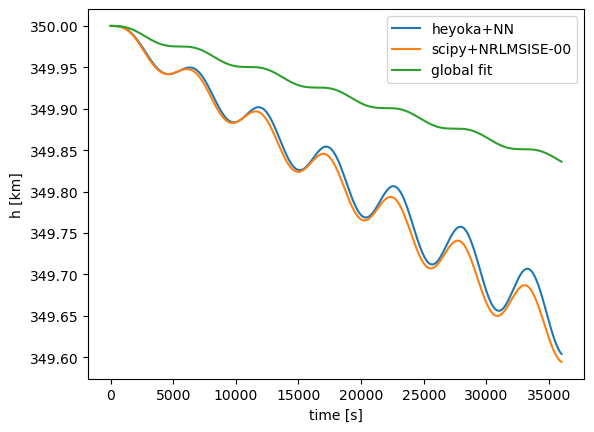

In [26]:
plt.plot(sol.t,(np.sqrt(res_x_heyoka_nn**2+res_y_heyoka_nn**2+res_z_heyoka_nn**2)-r_earth)*1e-3,label='heyoka+NN')
plt.plot(sol.t,(np.sqrt(res_x_scipy_nrlmsise00**2+res_y_scipy_nrlmsise00**2+res_z_scipy_nrlmsise00**2)-r_earth)*1e-3,label='scipy+NRLMSISE-00')
plt.plot(sol.t,(np.sqrt(res_x_heyoka_fit_global**2+res_y_heyoka_fit_global**2+res_z_heyoka_fit_global**2)-r_earth)*1e-3,label='global fit')
plt.legend()
plt.ylabel('h [km]')
plt.xlabel('time [s]')

In [27]:
print("######### global fit vs NRLMSISE-00 #########")
print("Maximum difference across the integration period:",1e3*max(abs((np.sqrt(res_x_heyoka_fit_global**2+res_y_heyoka_fit_global**2+res_z_heyoka_fit_global**2)-r_earth)*1e-3-(np.sqrt(res_x_scipy_nrlmsise00**2+res_y_scipy_nrlmsise00**2+res_z_scipy_nrlmsise00**2)-r_earth)*1e-3)))
print("Final difference:",1e3*(abs((np.sqrt(res_x_heyoka_fit_global[-1]**2+res_y_heyoka_fit_global[-1]**2+res_z_heyoka_fit_global[-1]**2)-r_earth)*1e-3-(np.sqrt(res_x_scipy_nrlmsise00[-1]**2+res_y_scipy_nrlmsise00[-1]**2+res_z_scipy_nrlmsise00[-1]**2)-r_earth)*1e-3)))

print("\n\n######### NN vs NRLMSISE-00 #########")
print("Maximum difference across the integration period:",1e3*max(abs((np.sqrt(res_x_heyoka_nn**2+res_y_heyoka_nn**2+res_z_heyoka_nn**2)-r_earth)*1e-3-(np.sqrt(res_x_scipy_nrlmsise00**2+res_y_scipy_nrlmsise00**2+res_z_scipy_nrlmsise00**2)-r_earth)*1e-3)))
print("Final difference:",1e3*(abs((np.sqrt(res_x_heyoka_nn[-1]**2+res_y_heyoka_nn[-1]**2+res_z_heyoka_nn[-1]**2)-r_earth)*1e-3-(np.sqrt(res_x_scipy_nrlmsise00[-1]**2+res_y_scipy_nrlmsise00[-1]**2+res_z_scipy_nrlmsise00[-1]**2)-r_earth)*1e-3)))

######### global fit vs NRLMSISE-00 #########
Maximum difference across the integration period: 241.68232427820158
Final difference: 241.68232427820158


######### NN vs NRLMSISE-00 #########
Maximum difference across the integration period: 25.220775065008638
Final difference: 9.643930040340365


As we notice, the differentiable atmosphere manages to capture very well the underlying behavior of NRLMSISE-00, maintaining (for 10 hours integrations) differences always below 23 meters, with a final difference of 9.45 meters, in the altitude of the satellite at an initial altitude of 350km (where drag is one of the main perturbations).

Conversely, a global fit does not manage to maintain the same accuracy, reaching difference as high as 223 meters, and a final difference of 200 meters.